In [1]:
############################################
# imports
############################################

import pyBigWig
import scipy.io as sio
import numpy as np
import math 
import matplotlib.pyplot as plt
import os
import pandas as pd
from heapq import nlargest
import copy
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import seaborn as sns
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold
#chromosomes = [f'chr{chrom}' for chrom in chromosomes]

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}

#################################################################################
#create dark bins file if not already created
#################################################################################

# Check if the bins to remove file has already been created
bins_file_path = f'{output_directory}/bins_to_remove_res{resolution_label}.npz'
if os.path.exists(bins_file_path):
    print(f"{bins_file_path} already exists. Skipping computation.")
    #load the dark regions data and the A/B compartment data
    loaded_data = np.load(bins_file_path)
    # Convert the loaded data back into a dictionary with the same structure
    bins_to_remove = {chrom: loaded_data[chrom] for chrom in loaded_data}
else:
    bigwig_file = "../../bin/softwarefiles/dark_regions_hg19.bigWig"
    # Open the BigWig file
    bw = pyBigWig.open(bigwig_file)

    # Define the chromosomes you want to analyze
    chromosomes = ['chr' + str(i) for i in range(1, 23)] 

    # Define the threshold for removing bins based on average mappability
    threshold = mappability_threshold

    # Create a dictionary to store the bin indices to remove for each chromosome
    bins_to_remove = {}

    # Loop through each chromosome
    for chrom in chromosomes:
        chrom_size = bw.chroms(chrom)

        if chrom_size is None:
            print(f"Chromosome {chrom} not found in the BigWig file.")
            continue

        # Calculate the number of bins based on the specified resolution
        num_bins = math.ceil(chrom_size / resolution) #last bin may not be of size resolution

        # Create lists to store bin indices to remove
        remove_indices = []

        # Calculate average mappability for each bin
        for i in range(num_bins):
            # Determine the start and end positions of the bin
            start = i * resolution
            end = min((i + 1) * resolution, chrom_size)  # to account for last bin which may be incomplete

            # Extract the mappability values for the bin
            values = np.nan_to_num(bw.values(chrom, start, end))

            # Calculate the average mappability score for the bin
            avg_mappability = np.mean(values)

            # Check if the average mappability is below the threshold
            if avg_mappability < threshold:
                remove_indices.append(i)

        # Store the bin indices to remove for this chromosome
        bins_to_remove[chrom] = remove_indices

    # Close the BigWig file
    bw.close()

    # Convert the lists in bins_to_remove to numpy arrays
    for chrom in bins_to_remove:
        bins_to_remove[chrom] = np.array(bins_to_remove[chrom])

    # Save the dictionary as an .npz file
    np.savez(bins_file_path, **bins_to_remove)
    print(f"Bins to remove file created and saved to {bins_file_path}")

###########################################################################    
#create a dictionary of the A/B compartment calls for the bulk data
###########################################################################
bulk_data = {}
path_to_eigenvectors = '../../projects/single_cell_files/eigenvector/'

for i in range(1, 23):
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    bulk_data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    bulk_data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
    
###########################################################################
# download H3K9ac file if it does not exist
###########################################################################

def calculate_bin_averages(data, elements_per_bin):
    num_bins = math.ceil(len(data)/elements_per_bin)
    bin_averages = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * elements_per_bin
        end_index = min((i + 1) * elements_per_bin, len(data))
        bin_data = data[start_index:end_index]
        if len(bin_data) > 0:
            bin_averages[i] = np.mean(bin_data)
        else:
            bin_averages[i] = 0
    return np.nan_to_num(bin_averages, nan=0.0)

# Read chromosome sizes from hg19.autosome.chrom.sizes
lengths = {}
with open(chrom_file, 'r') as file:
    for line in file:
        chrom, size = line.strip().split()
        lengths[chrom] = int(size)

# Check if the output file already exists
output_file = f'../../bin/softwarefiles/h3k9ac_res{resolution}_GM12878.pkl'

if not os.path.exists(output_file):
    # Initialization
    chromosomes = list(lengths.keys())
    h3k9ac = {name: [] for name in chromosomes}

    bigwig_H3K9ac_path = '../../bin/softwarefiles/ENCFF128UVW_hg19_H3K9ac_GM12878.bigWig'
    if not os.path.exists(bigwig_H3K9ac_path):
        os.system(f'wget https://www.encodeproject.org/files/ENCFF128UVW/@@download/ENCFF128UVW.bigWig -O {bigwig_H3K9ac_path}')

    bigwig_H3K9ac = pyBigWig.open(bigwig_H3K9ac_path)
    
    # Process each chromosome
    for chromosome_name in chromosomes:
        start_position = 1
        end_position = lengths[chromosome_name]
        values_file1 = np.array(bigwig_H3K9ac.values(chromosome_name, start_position, end_position))
        h3k9ac[chromosome_name] = calculate_bin_averages(values_file1, resolution)

    # Save the results in a pickle file
    with open(output_file, 'wb') as file:
        pickle.dump(h3k9ac, file)
else:
    print(f"The file {output_file} already exists.")
    with open(output_file, 'rb') as file:
        h3k9ac = pickle.load(file)

################################################################################    
#make sure each GM12878 eigenvector has positive value for active A compartment
################################################################################
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    chromosome_key = f'chr{i}'
    h3k9ac_df = pd.DataFrame(h3k9ac[chromosome_key], columns=['H3K9ac_signal'])
    
    df_gm12878_positive = bulk_data[key_gm12878]['eigenvalue']  
    df_gm12878_negative = -bulk_data[key_gm12878]['eigenvalue']

    # Compute correlations by first ensuring eigenvector data is in DataFrame format
    corr_positive = df_gm12878_positive.corr(h3k9ac_df['H3K9ac_signal'])
    corr_negative = df_gm12878_negative.corr(h3k9ac_df['H3K9ac_signal'])
    if corr_negative > corr_positive:
        bulk_data[key_gm12878]['eigenvalue'] = -bulk_data[key_gm12878]['eigenvalue']
        print(f"Switched for chromosome {i}")    

###############################################################################    
#make sure each IMR90 eigenvector has consistent orientation with GM12878
################################################################################
for i in range(1, 23):
    # Construct keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    
    # Retrieve DataFrames for GM12878 and IMR90
    df_gm12878 = bulk_data[key_gm12878]
    df_imr90 = bulk_data[key_imr90]
    
    # Ensure data is in expected format
    if not df_gm12878.empty and not df_imr90.empty:
        # Concatenate DataFrames side-by-side
        combined_df = pd.concat([df_gm12878.reset_index(drop=True), df_imr90.reset_index(drop=True)], axis=1, keys=['gm12878', 'imr90'])
        
        # Drop rows with NaN values in either column
        combined_df.dropna(inplace=True)
        
        # Extract Series after dropping NaNs
        gm12878_series = combined_df['gm12878']['eigenvalue']
        imr90_series = combined_df['imr90']['eigenvalue']

        # Calculate correlations
        corr_positive = gm12878_series.corr(imr90_series)
        corr_negative = gm12878_series.corr(-imr90_series)

        # If negating IMR90 improves correlation, update the original data
        if corr_negative > corr_positive:
            bulk_data[key_imr90]['eigenvalue'] = -bulk_data[key_imr90]['eigenvalue']
            print(f"switched for chromosome {i}")

#The A/B compartments of the proper orientation before dropping dark regions
original_bulk_data = copy.deepcopy(bulk_data)

#################################################################################
#remove dark regions
#dark reigons are obviously correlated
#I want to remove dark regions to get meeaningfully correlated regions
###############################################################################

for i in range(1, 23):
    # Construct the keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector'
    chrom = f'chr{i}'

    # Check if the chromosome exists in the bins_to_remove and in the data
    if chrom in bins_to_remove and key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Retrieve the indices to remove for this chromosome
        indices_to_remove = bins_to_remove[chrom]

        # Initialize lists to hold valid indices for both DataFrames
        valid_indices = []
        
        for idx in indices_to_remove:
            if idx < len(bulk_data[key_gm12878]) and idx < len(bulk_data[key_imr90]):
                valid_indices.append(idx)
        
        # Now drop the valid indices from both DataFrames
        if valid_indices:
            bulk_data[key_gm12878] = bulk_data[key_gm12878].drop(valid_indices).reset_index(drop=True)
            bulk_data[key_imr90] = bulk_data[key_imr90].drop(valid_indices).reset_index(drop=True)

########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {correlation}')

                                                               
                                                               

bam_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam'
methy_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam/methylation/filter_low_qual'
software_directory='../../bin/softwarefiles'
chrom_file='../../bin/softwarefiles/hg19.autosome.chrom.sizes'
fragments_file='../../bin/softwarefiles/hg19_DpnII.txt'
output_directory='../../projects/single_cell_files'
hg19_fa_url='ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz'
filtered_list='../../projects/single_cell_files/filtered_bam_list.txt'
schicluster_env='schicluster2'
bisulfite_env='bisulfitehic27'
min_high_quality_reads='250000'
resolutions='1000000:1Mb'
impute='True'
cluster_compartments='False'
cumulant='False'
iterations='400'
chromosomes=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
dark_regions_hg19_url='https://www.encodeproject.org/files/ENCFF000EHJ/@@download/ENCFF000EHJ.bigWig'
mappability_threshold='0.6'
data_types=o

In [5]:
import h5py
import numpy as np
import pandas as pd
import os
from scipy.stats import pearsonr

def extract_prefixes(file_path):
    """Extract prefixes from the filtered_bam_list.txt file."""
    prefixes = []
    with open(file_path, 'r') as file:
        for line in file:
            # Assuming the prefix format is like "sc11.ACTTGA" or similar
            parts = line.strip().split('.')
            if len(parts) >= 2:
                prefix = parts[0] + '.' + parts[1]  # Concatenate the first two parts to get the full prefix
                prefixes.append(prefix)
    return prefixes

def load_h5_file(file_path, dataset_name):
    """Load a dataset from an HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name][:]
    return data

def get_best_correlated_vector(V, eigenvector):
    """Find the row in V that best correlates with the given eigenvector."""
    eigenvector = eigenvector.values.flatten()
    best_corr = -np.inf  # Initialize with a very low correlation
    best_index = -1
    best_vector = None

    # Check each row in V for correlation with the eigenvector
    for i in range(V.shape[0]):  # Iterate over all rows in V
        # Synchronize non-NaN data
        valid_indices = ~np.isnan(V[i, :]) & ~np.isnan(eigenvector)
        if np.any(valid_indices):
            corr, _ = pearsonr(V[i, valid_indices], eigenvector[valid_indices])
            if corr > best_corr:  # Check if this is the best correlation so far
                best_corr = corr
                best_index = i
                best_vector = V[i, :]

    return best_vector, best_index, best_corr

# Directory setup
output_directory = '../../projects/single_cell_files/'
filtered_bam_list = os.path.join(output_directory, 'filtered_bam_list.txt')
base_tensor_dir = os.path.join(output_directory, 'tensor_1Mb_AB_factors')

# Extract prefixes from the file
prefixes = extract_prefixes(filtered_bam_list)
print(f"Extracted prefixes: {prefixes}")

# Dictionary to hold the dataframes for each chromosome
chromosome_results = {}

def normalize_vectors(V):
    """Normalize the columns of V to have a norm of 1."""
    norms = np.linalg.norm(V, axis=0)
    norms[norms == 0] = 1  # Prevent division by zero
    V_normalized = V / norms
    return V_normalized

# Loop through each chromosome directory
for i in range(1, 23):
    chromosome = f'chr{i}'
    results_df = pd.DataFrame(columns=['Sample', 'A/B Compartment', 'Correlation With Bulk', 'Cell Type'])

    for prefix in prefixes:
        input_file = os.path.join(base_tensor_dir, chromosome, f'{prefix}_compartments.h5')
        output_dir = os.path.join(output_directory, 'tensor_1Mb_AB_calls', chromosome)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_file = os.path.join(output_dir, f'{prefix}_tensor_AB_compartment_call.h5')

        if os.path.exists(output_file):
            print(f"{output_file} already exists. Loading existing results.")
            with h5py.File(output_file, 'r') as output_h5:
                best_vector = output_h5['AB_Compartment'][:]
                best_corr = output_h5['correlation']
                cell_type = output_h5['cell_type']
 
        else:
            sample_id = prefix  
            cell_type = updated_cell_color_dict.get(sample_id, 'GM12878')  # Default set to GM12878
            key = f'res{resolution}_ch{i}_oe_{cell_type.upper()}_KR_eigenvector'  

            print(f"Processing sample_id: {sample_id}, cell_type: {cell_type}, key: {key}, resolution {resolution}")

            if key in original_bulk_data:
                tensor_factors = load_h5_file(input_file, '/compartment_factors')
                tensor_factors = normalize_vectors(tensor_factors)
                print(f"Loaded tensor factors from {input_file}, shape: {tensor_factors.shape}")
                bulk_eigenvector = original_bulk_data[key]['eigenvalue'][:-1]
                print(f"Bulk eigenvector shape: {bulk_eigenvector.shape}")

                best_vector, best_index, best_corr = get_best_correlated_vector(tensor_factors, bulk_eigenvector)
                print(f"Best correlation: {best_corr} at index {best_index}")

                # Save the results to the output file
                with h5py.File(output_file, 'w') as output_h5:
                    output_h5.create_dataset('AB_Compartment', data=best_vector)
                    output_h5.create_dataset('correlation', data=best_corr)
                    output_h5.create_dataset('cell_type', data=cell_type)

        new_row = pd.DataFrame({
            'Sample': [sample_id],
            'A/B Compartment': [best_vector],
            'Correlation With Bulk': [best_corr],
            'Cell Type': [cell_type]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    print(f"Finished processing {chromosome}, {results_df.shape[0]} rows added.")
    chromosome_results[chromosome] = results_df


Extracted prefixes: ['sc11.ACTTGA', 'sc11.CGATGT', 'sc11.GCCAAT', 'sc11.TAGCTT', 'sc12.ACTTGA', 'sc12.CGATGT', 'sc12.GCCAAT', 'sc13.GCCAAT', 'sc14.ACTTGA', 'sc14.CGATGT', 'sc14.GCCAAT', 'sc14.TAGCTT', 'sc15.ACTTGA', 'sc15.CGATGT', 'sc15.GCCAAT', 'sc15.TAGCTT', 'sc16.ACTTGA', 'sc16.CGATGT', 'sc16.GCCAAT', 'sc16.TAGCTT', 'sc17.ACTTGA', 'sc17.CGATGT', 'sc17.GCCAAT', 'sc17.TAGCTT', 'sc18.ACTTGA', 'sc18.CGATGT', 'sc18.GCCAAT', 'sc18.TAGCTT', 'sc19.ACTTGA', 'sc19.CGATGT', 'sc19.TAGCTT', 'sc1.ACTTGA', 'sc1.GCCAAT', 'sc1.TAGCTT', 'sc20.ACTTGA', 'sc21.GCCAAT', 'sc22.ACTTGA', 'sc22.GCCAAT', 'sc22.TAGCTT', 'sc23.CGATGT', 'sc23.TAGCTT', 'sc24.ACTTGA', 'sc24.CGATGT', 'sc24.GCCAAT', 'sc24.TAGCTT', 'sc25.ACTTGA', 'sc25.CGATGT', 'sc25.GCCAAT', 'sc25.TAGCTT', 'sc26.ACTTGA', 'sc26.GCCAAT', 'sc27.TAGCTT', 'sc28.ACTTGA', 'sc29.CGATGT', 'sc29.GCCAAT', 'sc29.TAGCTT', 'sc2.CGATGT', 'sc2.GCCAAT', 'sc2.TAGCTT', 'sc30.ACTTGA', 'sc30.CGATGT', 'sc30.GCCAAT', 'sc30.TAGCTT', 'sc31.ACTTGA', 'sc31.TAGCTT', 'sc32.ACTT

Best correlation: 0.012624930213112071 at index 1
Processing sample_id: sc18.GCCAAT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc18.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.12899991075723571 at index 0
Processing sample_id: sc18.TAGCTT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc18.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.0815593357371023 at index 1
Processing sample_id: sc19.ACTTGA, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc19.ACTTGA_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best 

Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc29.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.10008999321844383 at index 1
Processing sample_id: sc29.GCCAAT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc29.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.15814617199153025 at index 0
Processing sample_id: sc29.TAGCTT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc29.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.04721094139907647 at index 0
P

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc39.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.17490988871886784 at index 1
Processing sample_id: sc39.GCCAAT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc39.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.022228492667289695 at index 1
Processing sample_id: sc39.TAGCTT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc39.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.13516011824316546 at index 1
Processing sample_id: sc3.ACTTGA, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc4.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.14075893865282474 at index 0
Processing sample_id: sc5.CGATGT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc5.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.05733905073001141 at index 0
Processing sample_id: sc5.GCCAAT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc5.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.01270438160926409 at index 0
Processing sample_id: sc5.TAGCTT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor f

Processing sample_id: sc17.ACTTGA, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc17.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.1285015344770394 at index 0
Processing sample_id: sc17.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc17.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.11683604998101955 at index 1
Processing sample_id: sc17.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc17.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.10646627866250548 at index 1
Processing

Processing sample_id: sc25.ACTTGA, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc25.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.03953335217850964 at index 0
Processing sample_id: sc25.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc25.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.0324220217445834 at index 1
Processing sample_id: sc25.GCCAAT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc25.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.09965742294171988 at index 1
Processing sam

Processing sample_id: sc34.ACTTGA, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc34.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.024225600294690616 at index 1
Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc34.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.11431363433567188 at index 1
Processing sample_id: sc34.GCCAAT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc34.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.06212847269331054 at index 1
Processing s

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc43.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.23616386716068447 at index 0
Processing sample_id: sc43.TAGCTT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc43.TAGCTT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.0535993703899077 at index 1
Processing sample_id: sc44.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc44.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.13461637923762404 at index 0
Processing sample_id: sc44.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded ten

Processing sample_id: sc9.ACTTGA, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.15135556144721574 at index 1
Processing sample_id: sc9.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.04551385184818351 at index 0
Processing sample_id: sc9.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.04126717480884204 at index 1
Processing 

Processing sample_id: sc17.GCCAAT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc17.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.0780506240960125 at index 1
Processing sample_id: sc17.TAGCTT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc17.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.16136361889812093 at index 1
Processing sample_id: sc18.ACTTGA, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc18.ACTTGA_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.062441966857727925 at index 1
Processin

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc25.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.0399116665468052 at index 0
Processing sample_id: sc25.TAGCTT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc25.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.12207792968250811 at index 0
Processing sample_id: sc26.ACTTGA, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc26.ACTTGA_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.1178849053998576 at index 0
Processing sample_id: sc26.GCCAAT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tens

Processing sample_id: sc35.CGATGT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc35.CGATGT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.08617015397486122 at index 0
Processing sample_id: sc36.GCCAAT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc36.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.09230189720646423 at index 1
Processing sample_id: sc36.TAGCTT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc36.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.13310959421444277 at index 1
Proce

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc44.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.006667378306446768 at index 0
Processing sample_id: sc45.CGATGT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc45.CGATGT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.04482822141610373 at index 0
Processing sample_id: sc46.CGATGT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc46.CGATGT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.113732681243611 at index 0
Processing sample_id: sc46.TAGCTT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded ten

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc12.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.37951350730353983 at index 0
Processing sample_id: sc13.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc13.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.38051472628206384 at index 1
Processing sample_id: sc14.ACTTGA, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc14.ACTTGA_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.4738431034083656 at index 0
Processing sample_id: sc14.CGATGT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded ten

Processing sample_id: sc1.TAGCTT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc1.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.24603238923711104 at index 1
Processing sample_id: sc20.ACTTGA, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc20.ACTTGA_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: -0.006708549724474199 at index 1
Processing sample_id: sc21.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc21.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.3646045777080471 at index 1
Processing sam

Processing sample_id: sc2.TAGCTT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc2.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.023105140886925182 at index 0
Processing sample_id: sc30.ACTTGA, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc30.ACTTGA_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.1205368670913296 at index 1
Processing sample_id: sc30.CGATGT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc30.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.245062545358262 at index 1
Processin

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc40.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.22026482651384938 at index 0
Processing sample_id: sc40.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc40.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.12286127927916601 at index 0
Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc40.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.2890552254225602 at index 0
Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded ten

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc4.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.1121728774256371 at index 0
Processing sample_id: sc4.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc4.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.4088990180567046 at index 0
Processing sample_id: sc5.CGATGT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc5.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.26421604737148846 at index 0
Processing sample_id: sc5.GCCAAT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor fac

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc16.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.18295071530949372 at index 0
Processing sample_id: sc16.GCCAAT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc16.GCCAAT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.12380492164310315 at index 0
Processing sample_id: sc16.TAGCTT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc16.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.04604286556925245 at index 0
Processing sample_id: sc17.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor

Processing sample_id: sc24.TAGCTT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc24.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.11771947308166637 at index 1
Processing sample_id: sc25.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc25.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.03976885176581608 at index 1
Processing sample_id: sc25.CGATGT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc25.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.11046740789161659 at index 1
Processing sa

Processing sample_id: sc34.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc34.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.16079527074657476 at index 1
Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc34.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.06187261678873186 at index 1
Processing sample_id: sc34.GCCAAT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc34.GCCAAT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.18174576145885857 at index 1
Processing sa

Best correlation: 0.3773100672535623 at index 0
Processing sample_id: sc42.CGATGT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc42.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.17867553931254707 at index 1
Processing sample_id: sc42.TAGCTT, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc42.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.32672809036393313 at index 1
Processing sample_id: sc43.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc43.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best corre

Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc7.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.10657514248072063 at index 0
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc7.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.1584683511659284 at index 1
Processing sample_id: sc8.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc8.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.1632813697442341 at index 1
Processing sample_id:

Processing sample_id: sc19.ACTTGA, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc19.ACTTGA_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.23406863173297693 at index 0
Processing sample_id: sc19.CGATGT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc19.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.2171063781092808 at index 0
Processing sample_id: sc19.TAGCTT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc19.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.00473070252617378 at index 0
Processing sam

Best correlation: 0.3065376354942655 at index 0
Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc29.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.08505794149467631 at index 0
Processing sample_id: sc29.GCCAAT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc29.GCCAAT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.018747524240647132 at index 0
Processing sample_id: sc29.TAGCTT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc29.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
B

Processing sample_id: sc37.CGATGT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc37.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: -0.008595018890350326 at index 0
Processing sample_id: sc37.GCCAAT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc37.GCCAAT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.31112392809476636 at index 0
Processing sample_id: sc37.TAGCTT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc37.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.08461380657466838 at index 1
Process

Best correlation: 0.1600530379154227 at index 1
Processing sample_id: sc46.TAGCTT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc46.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.12455331108821603 at index 1
Processing sample_id: sc47.ACTTGA, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc47.ACTTGA_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.07569694301463446 at index 0
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc47.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best corre

Best correlation: 0.16426495349440448 at index 1
Processing sample_id: sc15.CGATGT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc15.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.061689565628252 at index 0
Processing sample_id: sc15.GCCAAT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc15.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.19974109934508008 at index 0
Processing sample_id: sc15.TAGCTT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc15.TAGCTT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correl

Best correlation: 0.07406194813883486 at index 0
Processing sample_id: sc24.ACTTGA, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc24.ACTTGA_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.2249814359277103 at index 1
Processing sample_id: sc24.CGATGT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc24.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.08802765345413358 at index 0
Processing sample_id: sc24.GCCAAT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc24.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best corre

Best correlation: 0.13637254291208725 at index 0
Processing sample_id: sc37.ACTTGA, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc37.ACTTGA_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.1644094300961344 at index 0
Processing sample_id: sc37.CGATGT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc37.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.04877503686026766 at index 1
Processing sample_id: sc37.GCCAAT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc37.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best corre

Processing sample_id: sc46.TAGCTT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc46.TAGCTT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.23174420383642008 at index 0
Processing sample_id: sc47.ACTTGA, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc47.ACTTGA_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.07986857270039643 at index 1
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc47.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.19105593094399514 at index 0
Processin

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc14.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.18180222171138702 at index 0
Processing sample_id: sc15.ACTTGA, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc15.ACTTGA_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.1588535916131804 at index 1
Processing sample_id: sc15.CGATGT, cell_type: gm12878, key: res1000000_ch8_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc15.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.10658466643740734 at index 1
Processing sample_id: sc15.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded ten

Best correlation: 0.1849114047594953 at index 1
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc22.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.06794339849984407 at index 1
Processing sample_id: sc23.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc23.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: -0.02892437468307986 at index 1
Processing sample_id: sc23.TAGCTT, cell_type: gm12878, key: res1000000_ch8_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc23.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best corr

Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc32.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.21620062245018884 at index 0
Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc32.GCCAAT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.1133505879732803 at index 0
Processing sample_id: sc32.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc32.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.041375151957283834 at index 1
Processing sa

Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc41.ACTTGA_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.22898347257440227 at index 1
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc41.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: -0.007732580101931955 at index 1
Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc41.GCCAAT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.03300141552328657 at index 1
Processing 

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc5.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.05971464503879127 at index 0
Processing sample_id: sc6.ACTTGA, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc6.ACTTGA_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.031840156930525755 at index 0
Processing sample_id: sc6.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc6.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.11001732929170124 at index 1
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor fact

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc15.GCCAAT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.16131499814287048 at index 0
Processing sample_id: sc15.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc15.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1532309137545366 at index 1
Processing sample_id: sc16.ACTTGA, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc16.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.18509125753265018 at index 1
Processing sample_id: sc16.CGATGT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor 

Processing sample_id: sc23.TAGCTT, cell_type: gm12878, key: res1000000_ch9_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc23.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.11666645921485441 at index 0
Processing sample_id: sc24.ACTTGA, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc24.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.17648930982647817 at index 1
Processing sample_id: sc24.CGATGT, cell_type: gm12878, key: res1000000_ch9_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc24.CGATGT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.13937192878300395 at index 1
Proce

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc32.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1926048879389607 at index 0
Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc32.CGATGT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1905710432578848 at index 0
Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc32.GCCAAT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.3191753223131037 at index 0
Processing sample_id: sc32.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor fa

Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc41.CGATGT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.03171702625550119 at index 0
Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc41.GCCAAT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1656984891308919 at index 1
Processing sample_id: sc41.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc41.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.12072298312853794 at index 0
Processing sam

Best correlation: 0.07318241690281314 at index 0
Processing sample_id: sc6.CGATGT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc6.CGATGT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.10506281963317189 at index 1
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc6.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1730258188893777 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc7.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.

Best correlation: 0.15704298788301188 at index 1
Processing sample_id: sc19.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc19.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.12398831131189497 at index 1
Processing sample_id: sc19.CGATGT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc19.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.22430325503628376 at index 0
Processing sample_id: sc19.TAGCTT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc19.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best co

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc2.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.33334501157037666 at index 0
Processing sample_id: sc2.GCCAAT, cell_type: gm12878, key: res1000000_ch10_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc2.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.21053522759405358 at index 0
Processing sample_id: sc2.TAGCTT, cell_type: gm12878, key: res1000000_ch10_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc2.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.09629314498840957 at index 0
Processing sample_id: sc30.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Load

Processing sample_id: sc39.GCCAAT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc39.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.2810325436208598 at index 0
Processing sample_id: sc39.TAGCTT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc39.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.1680858026201534 at index 1
Processing sample_id: sc3.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc3.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.1326404056777211 at index 1
Processing s

Best correlation: 0.18740805307625755 at index 0
Processing sample_id: sc6.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc6.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.11197800147439492 at index 1
Processing sample_id: sc6.CGATGT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc6.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.03245839484833284 at index 0
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc6.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlat

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc15.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.1889525576155569 at index 1
Processing sample_id: sc16.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc16.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.16512205075683126 at index 1
Processing sample_id: sc16.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc16.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.09892882332256984 at index 1
Processing sample_id: sc16.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded t

Processing sample_id: sc24.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc24.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.0269169021323219 at index 0
Processing sample_id: sc24.TAGCTT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc24.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.2260882320578764 at index 1
Processing sample_id: sc25.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc25.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.23522028777650483 at index 1
Processin

Processing sample_id: sc33.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc33.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.03549616847554692 at index 1
Processing sample_id: sc34.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc34.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.16331875368989948 at index 0
Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc34.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.10765432847992144 at index 1
Process

Processing sample_id: sc42.ACTTGA, cell_type: gm12878, key: res1000000_ch11_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc42.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.14319711318181552 at index 0
Processing sample_id: sc42.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc42.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.28720216802501 at index 1
Processing sample_id: sc42.TAGCTT, cell_type: gm12878, key: res1000000_ch11_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc42.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.11129226479821472 at index 1
Pr

Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc6.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.13969649014000401 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc7.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.01675622202144169 at index 1
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc7.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.1315173989858635 at index 0
Processing sam

Best correlation: 0.16170677072610112 at index 1
Processing sample_id: sc16.CGATGT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc16.CGATGT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.04017325452540501 at index 1
Processing sample_id: sc16.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc16.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.054518653822071425 at index 0
Processing sample_id: sc16.TAGCTT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc16.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best c

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc26.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.18626687509534198 at index 1
Processing sample_id: sc27.TAGCTT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc27.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.05214430561489517 at index 1
Processing sample_id: sc28.ACTTGA, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc28.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: -0.020198258494324172 at index 0
Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 10000

Best correlation: 0.25992892490572933 at index 1
Processing sample_id: sc39.ACTTGA, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc39.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.1458516266071383 at index 1
Processing sample_id: sc39.CGATGT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc39.CGATGT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.37340392143161977 at index 1
Processing sample_id: sc39.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc39.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best

Processing sample_id: sc5.GCCAAT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc5.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.12279992230999685 at index 0
Processing sample_id: sc5.TAGCTT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc5.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.08524282220820041 at index 0
Processing sample_id: sc6.ACTTGA, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc6.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.16987580988870532 at index 0
Processin

Processing sample_id: sc17.TAGCTT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc17.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.2709321428238991 at index 1
Processing sample_id: sc18.ACTTGA, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc18.ACTTGA_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.051073343806593764 at index 1
Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc18.CGATGT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.027379093118818587 at index 1
Pr

Processing sample_id: sc2.TAGCTT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc2.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.008288745240393056 at index 1
Processing sample_id: sc30.ACTTGA, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc30.ACTTGA_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.27003648066596353 at index 1
Processing sample_id: sc30.CGATGT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc30.CGATGT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.08635810407166215 at index 0


Processing sample_id: sc42.CGATGT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc42.CGATGT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.13583447955345568 at index 1
Processing sample_id: sc42.TAGCTT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc42.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.42919751142084267 at index 0
Processing sample_id: sc43.ACTTGA, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc43.ACTTGA_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.03310896171650897 at index 0
Pro

Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc12.ACTTGA_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.14722728376527233 at index 0
Processing sample_id: sc12.CGATGT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc12.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.3821986782911483 at index 1
Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc12.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.21355203114252178 at index 1
Proc

Best correlation: 0.3709364265955753 at index 0
Processing sample_id: sc24.CGATGT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc24.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.1410593146796067 at index 0
Processing sample_id: sc24.GCCAAT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc24.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.21339332830939475 at index 1
Processing sample_id: sc24.TAGCTT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc24.TAGCTT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best 

Processing sample_id: sc35.ACTTGA, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc35.ACTTGA_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.24314812031501803 at index 1
Processing sample_id: sc35.CGATGT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc35.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.20141484235397492 at index 1
Processing sample_id: sc36.GCCAAT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc36.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.06835414845746053 at index 0
Pro

Processing sample_id: sc47.GCCAAT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc47.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.11805165483080027 at index 1
Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc47.TAGCTT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.3695253326458506 at index 0
Processing sample_id: sc48.CGATGT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc48.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.20457454679223422 at index 1
Proc

Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc12.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.041068522824652336 at index 0
Processing sample_id: sc13.GCCAAT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc13.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.2518807538337527 at index 1
Processing sample_id: sc14.ACTTGA, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc14.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.21609430378504432 at index 1
Pro

Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc22.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.19062420305627847 at index 1
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc22.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.02120701010713826 at index 0
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc22.TAGCTT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.6089488009890816 at index 1
Proc

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc35.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.194967206227299 at index 1
Processing sample_id: sc35.CGATGT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc35.CGATGT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.2708795491076972 at index 0
Processing sample_id: sc36.GCCAAT, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc36.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.16703046563441182 at index 0
Processing sample_id: sc36.TAGCTT, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Lo

Processing sample_id: sc4.ACTTGA, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc4.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.6730563113469832 at index 1
Processing sample_id: sc4.CGATGT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc4.CGATGT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.28728597982699045 at index 0
Processing sample_id: sc4.GCCAAT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc4.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.39716774723498305 at index 1
Processing

Processing sample_id: sc16.TAGCTT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc16.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.02754424960620947 at index 0
Processing sample_id: sc17.ACTTGA, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc17.ACTTGA_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.14663714879428885 at index 0
Processing sample_id: sc17.CGATGT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc17.CGATGT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.022665048564149533 at index 0
Processing s

Best correlation: 0.21217541257153572 at index 0
Processing sample_id: sc2.TAGCTT, cell_type: gm12878, key: res1000000_ch16_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc2.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.1635202638836188 at index 1
Processing sample_id: sc30.ACTTGA, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc30.ACTTGA_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.07498740707986386 at index 1
Processing sample_id: sc30.CGATGT, cell_type: gm12878, key: res1000000_ch16_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc30.CGATGT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best cor

Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc41.CGATGT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.04794187129197172 at index 0
Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc41.GCCAAT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.15545825295046528 at index 1
Processing sample_id: sc41.TAGCTT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc41.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.2930516709888318 at index 1
Processing sam

Processing sample_id: sc9.TAGCTT, cell_type: gm12878, key: res1000000_ch16_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc9.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.24045388063276255 at index 0
Finished processing chr16, 129 rows added.
Processing sample_id: sc11.ACTTGA, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc11.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.017328127913296878 at index 0
Processing sample_id: sc11.CGATGT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc11.CGATGT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correla

Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc22.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.08862301422483836 at index 1
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc22.GCCAAT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.3303891629392796 at index 1
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc22.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.09340603921614152 at index 1
Processing

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc32.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.13724641783677047 at index 1
Processing sample_id: sc33.GCCAAT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc33.GCCAAT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.3485207751157344 at index 1
Processing sample_id: sc34.ACTTGA, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc34.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.06496171802230385 at index 0
Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor 

Processing sample_id: sc46.CGATGT, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc46.CGATGT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.10093360789201973 at index 1
Processing sample_id: sc46.TAGCTT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc46.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.1971558875943379 at index 0
Processing sample_id: sc47.ACTTGA, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc47.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.08600447476511591 at index 1
Proces

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc12.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.24597919318751588 at index 1
Processing sample_id: sc13.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc13.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.24213126670952076 at index 1
Processing sample_id: sc14.ACTTGA, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc14.ACTTGA_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.055875979092646695 at index 0
Processing sample_id: sc14.CGATGT, cell_type: gm12878, key: res1000000_ch18_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded t

Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc22.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: -0.017862260816489315 at index 0
Processing sample_id: sc23.CGATGT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc23.CGATGT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.1804085807089771 at index 1
Processing sample_id: sc23.TAGCTT, cell_type: gm12878, key: res1000000_ch18_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc23.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.04697271436782787 at index 1
Processi

Best correlation: 0.09126131247398941 at index 0
Processing sample_id: sc33.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc33.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.012337387127165023 at index 1
Processing sample_id: sc34.ACTTGA, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc34.ACTTGA_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.04659219500755227 at index 1
Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc34.CGATGT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correla

Processing sample_id: sc43.TAGCTT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc43.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.014296864796280886 at index 1
Processing sample_id: sc44.CGATGT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc44.CGATGT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.09285536578315148 at index 0
Processing sample_id: sc44.GCCAAT, cell_type: gm12878, key: res1000000_ch18_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc44.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.24548675704833095 at index 0
Processi

Best correlation: 0.3769613174790689 at index 1
Processing sample_id: sc11.GCCAAT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc11.GCCAAT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.17989040649658375 at index 1
Processing sample_id: sc11.TAGCTT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc11.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.29927135894842904 at index 1
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc12.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best corre

Best correlation: 0.35252060032079174 at index 1
Processing sample_id: sc18.TAGCTT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc18.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.24713950985217786 at index 1
Processing sample_id: sc19.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc19.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.48502697959393226 at index 1
Processing sample_id: sc19.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc19.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best corr

Processing sample_id: sc30.GCCAAT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc30.GCCAAT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.1776887496402567 at index 1
Processing sample_id: sc30.TAGCTT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc30.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.6271152749539074 at index 1
Processing sample_id: sc31.ACTTGA, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc31.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.04269986951152694 at index 0
Processing 

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc3.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.2062703543523967 at index 0
Processing sample_id: sc3.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc3.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.3101433905198675 at index 0
Processing sample_id: sc40.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc40.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.22637577244252893 at index 1
Processing sample_id: sc40.GCCAAT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor fact

Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc6.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.32343641408799384 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc7.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.15400106269853897 at index 1
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc7.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.5105266619966804 at index 1
Processing sample_id

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc18.ACTTGA_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.41125460075150644 at index 0
Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc18.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.0688823020392189 at index 1
Processing sample_id: sc18.GCCAAT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc18.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.26709401965966173 at index 1
Processing sample_id: sc18.TAGCTT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Lo

Processing sample_id: sc28.ACTTGA, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc28.ACTTGA_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.28451610065778776 at index 1
Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc29.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.18722989262839304 at index 1
Processing sample_id: sc29.GCCAAT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc29.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.15845489460416773 at index 0
Proce

Processing sample_id: sc3.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc3.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.05189145823306713 at index 0
Processing sample_id: sc40.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc40.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.4875060574353464 at index 0
Processing sample_id: sc40.GCCAAT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc40.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.14072655655326494 at index 1
Processing sampl

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc6.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.05374851970882373 at index 1
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc6.TAGCTT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.20712595053158234 at index 0
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc7.ACTTGA_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.2740113814298599 at index 1
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factor

Best correlation: 0.5735156472267056 at index 1
Processing sample_id: sc19.TAGCTT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc19.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.3286142333648167 at index 0
Processing sample_id: sc1.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc1.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.0928086944571644 at index 1
Processing sample_id: sc1.GCCAAT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc1.GCCAAT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.

Processing sample_id: sc31.ACTTGA, cell_type: gm12878, key: res1000000_ch21_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc31.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.027859911272924087 at index 1
Processing sample_id: sc31.TAGCTT, cell_type: gm12878, key: res1000000_ch21_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc31.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.2564103615805431 at index 1
Processing sample_id: sc32.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc32.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.46349112836716133 at index 0
Proce

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc42.CGATGT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.31017351182521213 at index 1
Processing sample_id: sc42.TAGCTT, cell_type: gm12878, key: res1000000_ch21_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc42.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.42474896845424387 at index 1
Processing sample_id: sc43.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc43.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.26403397886114277 at index 0
Processing sample_id: sc43.TAGCTT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded te

Best correlation: 0.3964909334224494 at index 0
Finished processing chr21, 129 rows added.
Processing sample_id: sc11.ACTTGA, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc11.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.2818834875808433 at index 0
Processing sample_id: sc11.CGATGT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc11.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.4637072055280685 at index 0
Processing sample_id: sc11.GCCAAT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc11.GCCAAT_compartments.h5, shape: (2, 51)

Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc18.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.08787852566346162 at index 0
Processing sample_id: sc18.GCCAAT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc18.GCCAAT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.057833849760050855 at index 1
Processing sample_id: sc18.TAGCTT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc18.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.12828916755334577 at index 1


Best correlation: 0.10493909015894289 at index 1
Processing sample_id: sc30.CGATGT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc30.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.002014531785073806 at index 0
Processing sample_id: sc30.GCCAAT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc30.GCCAAT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.3371701807660857 at index 0
Processing sample_id: sc30.TAGCTT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc30.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best corr

Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc40.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.22599366220276546 at index 1
Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc41.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.11496632057155115 at index 1
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc41.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.17709096951648315 at index 0
Processin

Processing sample_id: sc6.CGATGT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc6.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.07670133782221966 at index 1
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc6.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.1960877625968026 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc7.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.21463203395718733 at index 0
Processing sample_id

In [6]:
chromosome_results['chr1']

,Sample,A/B Compartment,Correlation With Bulk,Cell Type
0,sc11.ACTTGA,"[0.7150486953979197, 0.9999999988975657, 1.0, ...",0.115300,gm12878
1,sc11.CGATGT,"[2.974398511048887e-06, 9.214124800326177e-57,...",0.169729,imr90
2,sc11.GCCAAT,"[1.3714279531549147e-06, 9.515786268038794e-05...",0.163800,imr90
3,sc11.TAGCTT,"[0.43728710335236876, 1.0, 0.9858501871060783,...",0.077578,gm12878
4,sc12.ACTTGA,"[7.493531792809511e-44, 0.4482986710905231, 0....",0.046052,imr90
...,...,...,...,...
124,sc8.ACTTGA,"[0.40519951922747194, 0.4080021003048177, 0.99...",0.044051,imr90
125,sc9.ACTTGA,"[0.47975930213442053, 0.456413353598784, 0.995...",0.044944,gm12878
126,sc9.CGATGT,"[0.3942128380310878, 0.443401884539195, 7.7988...",0.080890,imr90
127,sc9.GCCAAT,"[1.0, 0.7413380425594076, 0.9999999998770758, ...",0.116383,gm12878


In [9]:
prefix = 'sc19.TAGCTT'
output_directory = '../../projects/single_cell_files/'
output_dir = os.path.join(output_directory, 'tensor_1Mb_AB_calls', 'chr1')
output_file = os.path.join(output_dir, f'{prefix}_tensor_AB_compartment_call.h5')

with h5py.File(output_file, 'r') as output_h5:
    best_vector = output_h5['AB_Compartment'][:]
    best_corr = output_h5['correlation']
    cell_type = output_h5['cell_type']

In [23]:
import pandas as pd

chr=1    
# Assuming chromosome_results['chr1'] contains relevant data
sc_dataframe = chromosome_results[f'chr{chr}']

# First, sort by 'Cell Type' in a way that 'gm12878' cells come first, and then by 'Correlation With Bulk' descending
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'gm12878': 0, 'imr90': 1})  # Helps in sorting by cell type
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])

# Remove the auxiliary column after sorting
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

# Now sc_dataframe is sorted first by cell type ('gm12878' first) and then by 'Correlation With Bulk' within each type
sc_dataframe

,Sample,A/B Compartment,Correlation With Bulk,Cell Type
106,sc47.ACTTGA,"[0.9248298509943448, 0.7183716443110008, 0.239...",0.263927,gm12878
90,sc40.TAGCTT,"[0.656083608139672, 0.5716268424586586, 0.9999...",0.251934,gm12878
109,sc47.TAGCTT,"[1.0, 0.8805634784482768, 1.0, 1.0, 1.0, 1.0, ...",0.225521,gm12878
95,sc42.ACTTGA,"[0.16929768447590593, 0.4762892461475916, 0.99...",0.212725,gm12878
97,sc42.TAGCTT,"[0.0056137133676475775, 0.8993910867363266, 1....",0.207970,gm12878
...,...,...,...,...
49,sc26.ACTTGA,"[2.777027827050675e-10, 0.9997669348133172, 0....",0.014953,imr90
23,sc17.TAGCTT,"[0.1618601200327032, 0.9878507181276264, 2.859...",0.011414,imr90
98,sc43.ACTTGA,"[0.04874220001658534, 0.39584236697439834, 0.4...",0.010272,imr90
91,sc41.ACTTGA,"[0.6063816942558776, 0.3107944283414665, 0.109...",0.008525,imr90


In [25]:
gm12878_count = sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878'].shape[0]
gm12878_count

38

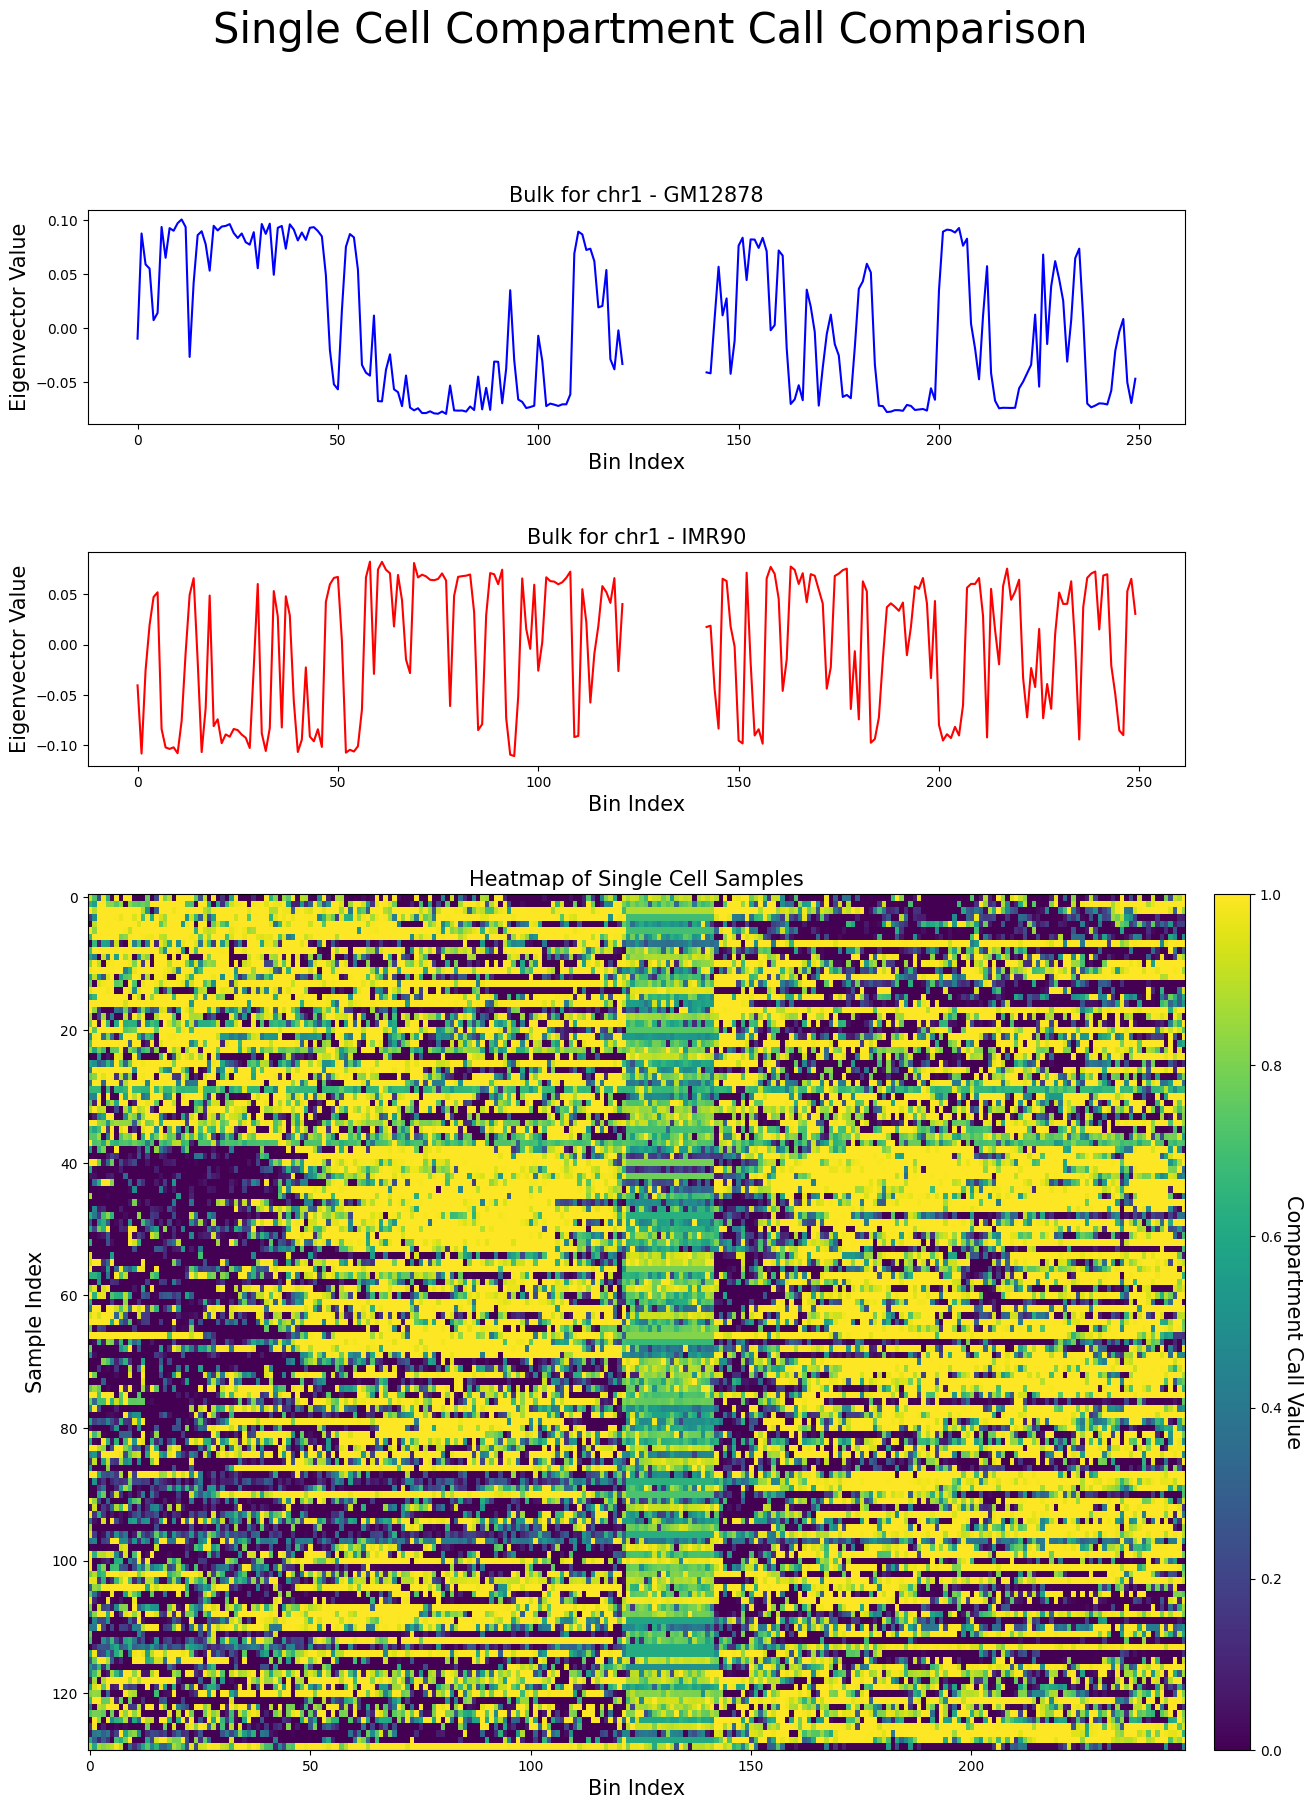

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title):
    fig = plt.figure(figsize=(15, 20))
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    # Plot Bulk Eigenvectors
    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='blue')
    ax_bulk1.set_title(title1, fontsize=15)
    ax_bulk1.set_xlabel("Bin Index", fontsize=15)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=15)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='red')
    ax_bulk2.set_title(title2, fontsize=15)
    ax_bulk2.set_xlabel("Bin Index", fontsize=15)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=15)

    # Create heatmap from 'A Compartment' column
    ax_sc = fig.add_subplot(gs[2, 0])
    # Extract all arrays from 'A Compartment' and stack them
    sc_data_array = np.stack(sc_dataframe['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='viridis', interpolation='nearest')
    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=15)
    ax_sc.set_xlabel("Bin Index", fontsize=15)
    ax_sc.set_ylabel("Sample Index", fontsize=15)

    # Colorbar for the heatmap
    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=15, fontsize=15)

    plt.suptitle(title, fontsize=30)
    plt.show()

# Example bulk eigenvector data, replace with your actual data
key_gm12878 = f'res{resolution}_ch{chr}_oe_GM12878_KR_eigenvector'
key_imr90 = f'res{resolution}_ch{chr}_oe_IMR90_KR_eigenvector'    

bulk_eigenvector_gm12878 = original_bulk_data[key_gm12878]['eigenvalue']
bulk_eigenvector_imr90 = original_bulk_data[key_imr90]['eigenvalue']

plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    "Bulk for chr1 - GM12878",
    "Bulk for chr1 - IMR90",
    "Single Cell Compartment Call Comparison"
)
